In [158]:
%matplotlib inline

import warnings
import os
from pathlib import Path
import quandl
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, IncrementalPCA, FastICA
from sklearn.preprocessing import scale

In [2]:
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
np.random.seed(42)

## Get returns for equities with highest market cap

In [287]:
idx = pd.IndexSlice
with pd.HDFStore('../../data/assets.h5') as store:
    stocks = store['us_equities/stocks'].marketcap.nlargest(500)
    returns = (store['quandl/wiki/prices']
               .loc[idx['2010': '2018', stocks.index], 'adj_close']
               .unstack('ticker')
               .pct_change())

In [288]:
returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2072 entries, 2010-01-04 to 2018-03-27
Columns: 351 entries, A to ZTS
dtypes: float64(351)
memory usage: 5.6 MB


### Winsorize returns

In [289]:
returns = returns.clip(lower=returns.quantile(q=.025), upper=returns.quantile(q=.975), axis=1)

### Impute missing values

In [290]:
returns = returns.dropna(thresh=int(returns.shape[0] * .95), axis=1)
returns = returns.dropna(thresh=int(returns.shape[1] * .95))
returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2070 entries, 2010-01-05 to 2018-03-27
Columns: 314 entries, A to ZBH
dtypes: float64(314)
memory usage: 5.0 MB


In [291]:
daily_avg = returns.mean(1)
returns = returns.apply(lambda x: x.fillna(daily_avg))

## Fit PCA

In [292]:
pca = PCA()
pca.fit(returns)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

### Visualize Explained Variance

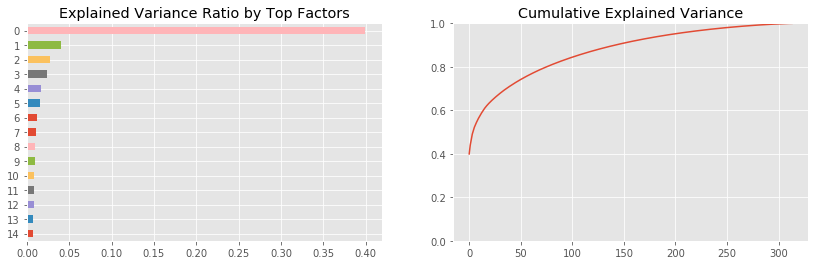

In [293]:
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
pd.Series(pca.explained_variance_ratio_).iloc[:15].sort_values().plot.barh(title='Explained Variance Ratio by Top Factors',ax=axes[0]);
pd.Series(pca.explained_variance_ratio_).cumsum().plot(ylim=(0,1),ax=axes[1], title='Cumulative Explained Variance');

In [295]:
risk_factors = pd.DataFrame(pca.transform(returns)[:, :2], 
                            columns=['Principal Component 1', 'Principal Component 2'], 
                            index=returns.index)
risk_factors.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2070 entries, 2010-01-05 to 2018-03-27
Data columns (total 2 columns):
Principal Component 1    2070 non-null float64
Principal Component 2    2070 non-null float64
dtypes: float64(2)
memory usage: 48.5 KB


In [296]:
risk_factors['Principal Component 1'].corr(risk_factors['Principal Component 2'])

7.773256996252084e-15

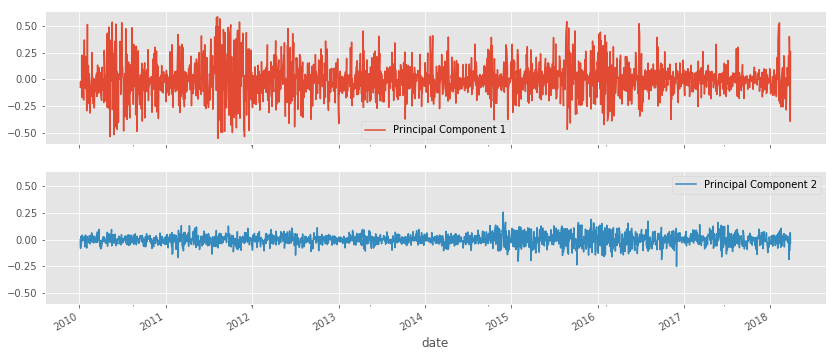

In [297]:
risk_factors.plot(subplots=True, figsize=(14,6), sharey=True);

## Simulation for larger number of stocks

In [298]:
idx = pd.IndexSlice
with pd.HDFStore('../../data/assets.h5') as store:
    returns = (store['quandl/wiki/prices']
              .loc[idx['2000': '2018', :], 'adj_close']
              .unstack('ticker')
              .pct_change())

In [299]:
pca = PCA()
n_trials, n_samples = 100, 500
explained = np.empty(shape=(n_trials, n_samples))
for trial in range(n_trials):
    returns_sample = returns.sample(n=n_samples)
    returns_sample = returns_sample.dropna(thresh=int(returns_sample.shape[0] * .95), axis=1)
    returns_sample = returns_sample.dropna(thresh=int(returns_sample.shape[1] * .95))
    daily_avg = returns_sample.mean(1)
    returns_sample = returns_sample.apply(lambda x: x.fillna(daily_avg))
    pca.fit(returns_sample)
    explained[trial, :len(pca.components_)] = pca.explained_variance_ratio_

In [300]:
explained = pd.DataFrame(explained, columns=list(range(1, explained.shape[1] + 1)))
explained.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 500 entries, 1 to 500
dtypes: float64(500)
memory usage: 390.7 KB


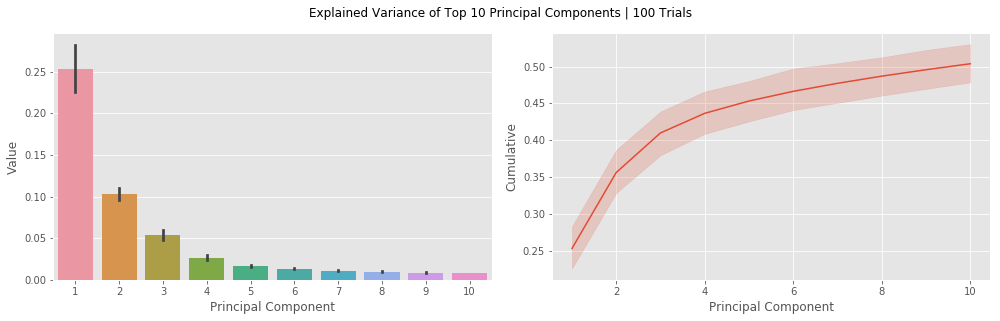

In [301]:
fig, axes =plt.subplots(ncols=2, figsize=(14, 4.5))
pc10 = explained.iloc[:, :10].stack().reset_index()
pc10.columns = ['Trial','Principal Component', 'Value']

pc10['Cumulative'] = pc10.groupby('Trial').Value.transform(np.cumsum)
sns.barplot(x='Principal Component', y='Value', data=pc10, ax=axes[0])
sns.lineplot(x='Principal Component', y='Cumulative', data=pc10, ax=axes[1])
fig.suptitle('Explained Variance of Top 10 Principal Components | 100 Trials')
fig.tight_layout()
fig.subplots_adjust(top=.90);

## Eigen Portfolios

In [251]:
idx = pd.IndexSlice
with pd.HDFStore('../../data/assets.h5') as store:
    stocks = store['us_equities/stocks'].marketcap.nlargest(30)
    returns = (store['quandl/wiki/prices']
               .loc[idx['2010': '2018', stocks.index], 'adj_close']
               .unstack('ticker')
               .pct_change())

In [252]:
normed_returns = scale(returns
                       .clip(lower=returns.quantile(q=.025), 
                             upper=returns.quantile(q=.975), 
                             axis=1))

In [253]:
returns = returns.dropna(thresh=int(returns.shape[0] * .95), axis=1)
returns = returns.dropna(thresh=int(returns.shape[1] * .95))
returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2069 entries, 2010-01-05 to 2018-03-27
Data columns (total 23 columns):
AAPL     2069 non-null float64
AMZN     2069 non-null float64
BA       2069 non-null float64
BAC      2069 non-null float64
CSCO     2069 non-null float64
CVX      2069 non-null float64
GOOGL    2069 non-null float64
HD       2069 non-null float64
INTC     2069 non-null float64
JNJ      2069 non-null float64
JPM      2069 non-null float64
KO       2069 non-null float64
MA       2068 non-null float64
MSFT     2069 non-null float64
PFE      2069 non-null float64
PG       2069 non-null float64
T        2069 non-null float64
UNH      2069 non-null float64
V        2069 non-null float64
VZ       2069 non-null float64
WFC      2069 non-null float64
WMT      2069 non-null float64
XOM      2069 non-null float64
dtypes: float64(23)
memory usage: 387.9 KB


In [254]:
cov = returns.cov()

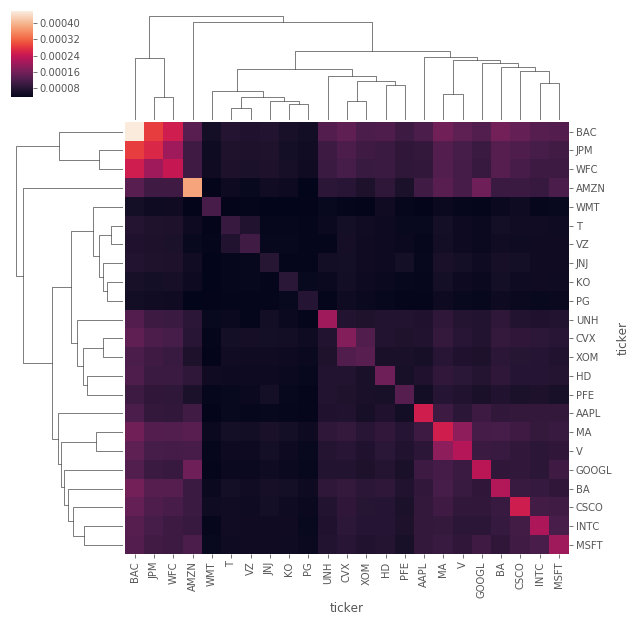

In [255]:
sns.clustermap(cov);

In [308]:
pca.fit(cov)
pd.Series(pca.explained_variance_ratio_).to_frame('Explained Variance').head().style.format('{:,.2%}'.format)

,Explained Variance
0,55.91%
1,15.52%
2,5.36%
3,4.85%
4,3.32%


In [272]:
top4 = pd.DataFrame(pca.components_[:4], columns=cov.columns)
eigen_portfolios = top4.div(top4.sum(1), axis=0)
eigen_portfolios.index = [f'Portfolio {i}' for i in range(1, 5)]

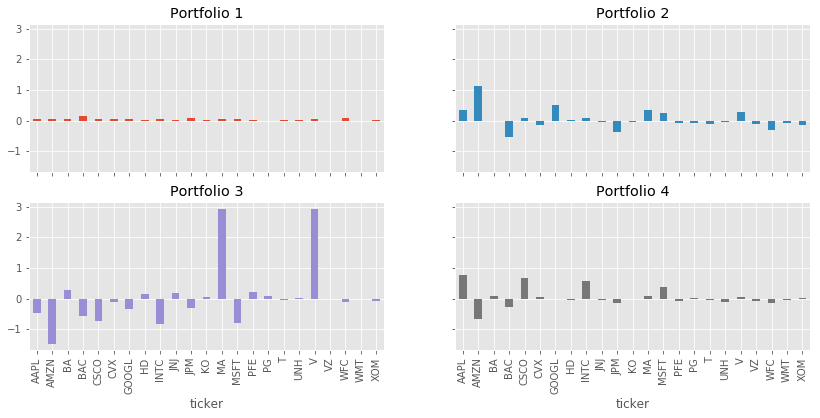

In [285]:
eigen_portfolios.T.plot.bar(subplots=True, layout=(2,2), figsize=(14,6), legend=False, sharey=True);

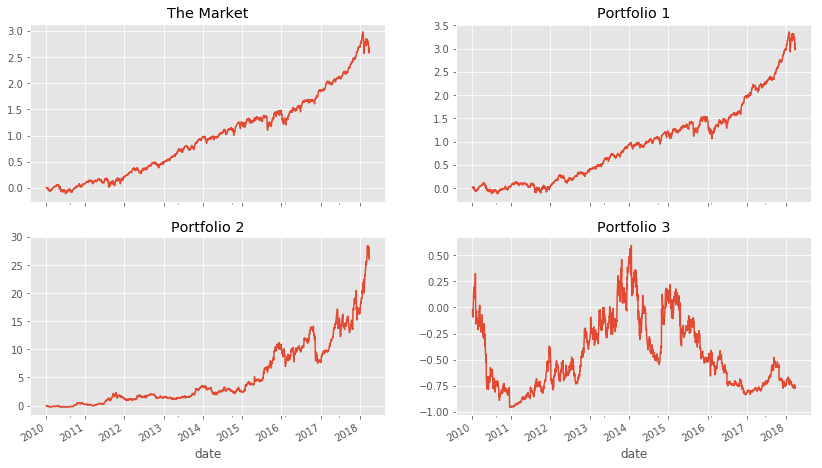

In [283]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,8), sharex=True)
axes = axes.flatten()
returns.mean(1).add(1).cumprod().sub(1).plot(title='The Market', ax=axes[0]);
for i in range(3):
    returns.mul(eigen_portfolios.iloc[i]).sum(1).add(1).cumprod().sub(1).plot(title=f'Portfolio {i+1}', ax=axes[i+1]);